In [1]:
import json
from preprocessor.preprocessor_pytorch import Preprocessor
from model.model_pytorch import Model
from postprocessor.postprocessor import Postprocesser
from evaluator.evaluator_pytorch import Evaluator
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import os
import time
import pickle
from sklearn.model_selection import train_test_split

class ReversePrediction():
    def set_seed(self, seed_value):
        np.random.seed(seed_value)
        tf.random.set_seed(seed_value)
        random.seed(seed_value)
        torch.manual_seed(seed_value)


    def run(self, params): 
        self.set_seed(42)
        preprocessor = Preprocessor(params)
        X_train, y_train, X_val, y_val, X_test, y_test, test_dates, X_newest, x_newest_date, y_newest_date, target_symbol_data = preprocessor.get_multiple_data()
        
        start_time = time.time()
        model_wrapper = Model(params=params)
        model, history, y_preds, online_training_losses, online_training_acc = \
            model_wrapper.run(X_train, y_train, X_test, y_test, X_val, y_val)
        y_pred_newest = model.forward(X_newest)
        end_time = time.time()
        execution_time = end_time - start_time
        
        y_preds = torch.tensor(y_preds, dtype=torch.float32)
        y_preds = preprocessor.change_values_after_first_reverse_point(y_preds)
        y_pred_newest = torch.tensor(y_pred_newest, dtype=torch.float32)
        y_pred_newest_filtered = preprocessor.change_values_after_first_reverse_point(y_pred_newest)
        
        postprocessor = Postprocesser()
        X_train, X_test, X_newest, y_train, y_test, y_preds = \
            postprocessor.check_shape(X_train, X_test, X_newest, y_train, y_test, y_preds, reshape=params['model_params'][params['model_type']]['reshape'])
        test_trade_signals = postprocessor.process_signals(y_test, test_dates, False)
        pred_trade_signals = postprocessor.process_signals(y_preds, test_dates, params['filter'])
        newest_trade_signals = postprocessor.process_signals(y_pred_newest_filtered, y_newest_date, params['filter'])
        
        evaluator = Evaluator(params=params)
        model_summary, pred_days_difference_results, pred_days_difference_abs_mean, backtesting_report, trade_summary, execution_time, confusion_matrix_info, y_test, y_preds = evaluator.generate_numericale_data(model,
                        y_test, y_preds, target_symbol_data, pred_trade_signals, test_trade_signals, execution_time)
        
        return model_summary, pred_days_difference_results, pred_days_difference_abs_mean, backtesting_report, trade_summary, execution_time, confusion_matrix_info, y_test, y_preds, test_trade_signals, y_pred_newest, pred_trade_signals, newest_trade_signals

    def run_2(self, params):
        self.set_seed(42)
        preprocessor = Preprocessor(params)
        train_indices = preprocessor.params['train_indices']
        test_indice = preprocessor.params['test_indices']

        test_dataset = preprocessor.fetch_stock_data(test_indice, preprocessor.params['start_date'], preprocessor.params['stop_date'])
        for single_feature_params in preprocessor.params['features_params']:
            feature_type = single_feature_params["type"]
            test_dataset = preprocessor.add_feature(test_dataset, feature_type, **single_feature_params)
        test_dataset, issues_detected = preprocessor.add_data_cleaner(test_dataset,
            clean_type=preprocessor.params['data_cleaning']['clean_type'], strategy=preprocessor.params['data_cleaning']['strategy'])
        X_train, y_train, X_test, y_test, _, test_dates = \
            preprocessor.process_data(test_dataset, split_ratio=preprocessor.params['split_ratio'], target_col=preprocessor.params['target_col'],
                                    feature_cols=preprocessor.params['feature_cols'], look_back=preprocessor.params['look_back'],
                                    predict_steps=preprocessor.params['predict_steps'],
                                    train_slide_steps=preprocessor.params['train_slide_steps'],
                                    test_slide_steps=preprocessor.params['test_slide_steps'],
                                    reshape=preprocessor.params['model_params'][preprocessor.params['model_type']]['reshape'])
        X_newest, x_newest_date, y_newest_date = preprocessor.create_x_newest_data(test_dataset, preprocessor.params['look_back'])
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
        target_symbol_data = test_dataset
        start_time = time.time()
        online_training_losses = []
        online_training_acc = []
        online_training_val_losses = []
        online_training_val_acc = []
        y_preds = []

        X_train_set = X_train
        y_train_set = y_train
        # params['training_epoch_num'] = 10
        for i in tqdm.tqdm(range(len(X_test))):
            model_wrapper = Model(params=params)
            input_shape = X_train.shape
            model = model_wrapper.create_model(model_wrapper.params['model_type'], input_shape)
            history, model = model_wrapper.train_model(model, X_train, y_train, X_val, y_val, model_wrapper.params['apply_weight'])
            y_pred = model_wrapper.infer_model(model, X_test[i:i+1])
            y_preds.append(y_pred[0])
            online_training_losses.append(history['loss'])
            online_training_acc.append(history['binary_accuracy'])
            online_training_val_losses.append(history['val_loss'])
            online_training_val_acc.append(history['val_binary_accuracy'])
            single_X_test = X_test[i:i+1]
            single_y_test = y_test[i:i+1]
            X_train_set = torch.cat((X_train_set[1:], single_X_test), dim=0)
            y_train_set = torch.cat((y_train_set[1:], single_y_test), dim=0)
            X_train, X_val, y_train, y_val = train_test_split(X_train_set, y_train_set, test_size=0.2, random_state=42)
            if preprocessor.params['filter_reverse_trend'] == "True":
                y_train = preprocessor.change_values_after_first_reverse_point(y_train)
                y_val = preprocessor.change_values_after_first_reverse_point(y_val)
                y_test = preprocessor.change_values_after_first_reverse_point(y_test)
        y_preds = torch.stack(y_preds).detach().numpy()
        end_time = time.time()
        execution_time = end_time - start_time
        y_preds = torch.tensor(y_preds, dtype=torch.float32)
        y_preds = preprocessor.change_values_after_first_reverse_point(y_preds)
        y_pred_newest = model.forward(X_newest)
        y_pred_newest = torch.tensor(y_pred_newest, dtype=torch.float32)
        y_pred_newest = preprocessor.change_values_after_first_reverse_point(y_pred_newest)
        postprocessor = Postprocesser()
        X_train, X_test, X_newest, y_train, y_test, y_preds = \
            postprocessor.check_shape(X_train, X_test, X_newest, y_train, y_test, y_preds, reshape=params['model_params'][params['model_type']]['reshape'])
        test_trade_signals = postprocessor.process_signals(y_test, test_dates, False)
        pred_trade_signals = postprocessor.process_signals(y_preds, test_dates, params['filter'])
        newest_trade_signals = postprocessor.process_signals(y_pred_newest, y_newest_date, False)
        evaluator = Evaluator(params=params)
        model_summary, pred_days_difference_results, pred_days_difference_abs_mean, backtesting_report, trade_summary, execution_time, confusion_matrix_info, y_test, y_preds = evaluator.generate_numericale_data(model,
                        y_test, y_preds, target_symbol_data, pred_trade_signals, test_trade_signals, execution_time)
        
        return model_summary, pred_days_difference_results, pred_days_difference_abs_mean, backtesting_report, trade_summary, execution_time, confusion_matrix_info, y_test, y_preds, test_trade_signals, pred_trade_signals, newest_trade_signals



In [2]:
with open('parameters.json', 'r') as f:
    params = json.load(f)

In [3]:
rp = ReversePrediction() 
rp.set_seed(42)

preprocessor = Preprocessor(params)
X_train, y_train, X_val, y_val, X_test, y_test, test_dates, X_newest, x_newest_date, y_newest_date, target_symbol_data = preprocessor.get_multiple_data()


[*********************100%***********************]  1 of 1 completed


c:\Users\e4903\Desktop\code\2023_hw\web\saferTrader\stock_project\revpred\lib\reversePrediction\preprocessor\preprocessor_pytorch.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 0 # up trend
c:\Users\e4903\Desktop\code\2023_hw\web\saferTrader\stock_project\revpred\lib\reversePrediction\preprocessor\preprocessor_pytorch.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 1 # down trend


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


c:\Users\e4903\Desktop\code\2023_hw\web\saferTrader\stock_project\revpred\lib\reversePrediction\preprocessor\preprocessor_pytorch.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 0 # up trend
c:\Users\e4903\Desktop\code\2023_hw\web\saferTrader\stock_project\revpred\lib\reversePrediction\preprocessor\preprocessor_pytorch.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 1 # down trend


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


c:\Users\e4903\Desktop\code\2023_hw\web\saferTrader\stock_project\revpred\lib\reversePrediction\preprocessor\preprocessor_pytorch.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 0 # up trend
c:\Users\e4903\Desktop\code\2023_hw\web\saferTrader\stock_project\revpred\lib\reversePrediction\preprocessor\preprocessor_pytorch.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 1 # down trend


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


c:\Users\e4903\Desktop\code\2023_hw\web\saferTrader\stock_project\revpred\lib\reversePrediction\preprocessor\preprocessor_pytorch.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 0 # up trend
c:\Users\e4903\Desktop\code\2023_hw\web\saferTrader\stock_project\revpred\lib\reversePrediction\preprocessor\preprocessor_pytorch.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 1 # down trend


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


c:\Users\e4903\Desktop\code\2023_hw\web\saferTrader\stock_project\revpred\lib\reversePrediction\preprocessor\preprocessor_pytorch.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 0 # up trend
c:\Users\e4903\Desktop\code\2023_hw\web\saferTrader\stock_project\revpred\lib\reversePrediction\preprocessor\preprocessor_pytorch.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 1 # down trend


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Training set shape: torch.Size([345, 32, 30])
Validation set shape: torch.Size([87, 32, 30])


In [4]:
start_time = time.time()
model_wrapper = Model(params=params)
model, history, y_preds, online_training_losses, online_training_acc = \
    model_wrapper.run(X_train, y_train, X_test, y_test, X_val, y_val)
end_time = time.time()
execution_time = end_time - start_time


  5%|▌         | 52/1000 [00:00<00:12, 77.49it/s]


In [5]:
y_preds = torch.tensor(y_preds, dtype=torch.float32)
y_preds = preprocessor.change_values_after_first_reverse_point(y_preds)


In [6]:
y_pred_newest = model.forward(X_newest)
y_pred_newest = torch.tensor(y_pred_newest, dtype=torch.float32)
y_pred_newest_filtered = preprocessor.change_values_after_first_reverse_point(y_pred_newest)

C:\Users\e4903\AppData\Local\Temp\ipykernel_17364\2422567768.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_newest = torch.tensor(y_pred_newest, dtype=torch.float32)


In [7]:
y_pred_newest

tensor([[[0.1364, 0.8623],
         [0.7900, 0.2096],
         [0.9173, 0.0824],
         [0.9353, 0.0650],
         [0.9684, 0.0318],
         [0.9729, 0.0271],
         [0.9677, 0.0316],
         [0.9706, 0.0293]]])

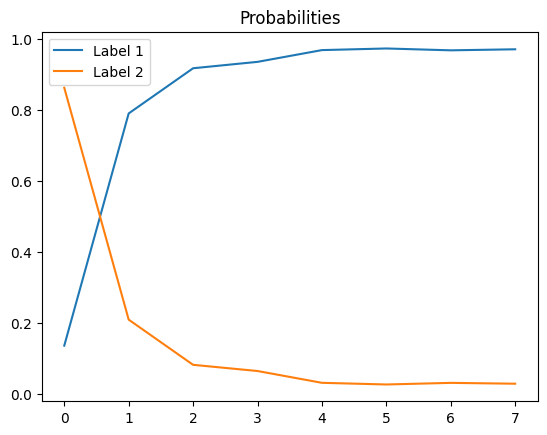

In [8]:
import matplotlib.pyplot as plt

# 定義標籤和機率值
labels = ['Label 1', 'Label 2']

# 將機率值分成兩個子列表，分別對應兩個標籤
prob_label1 = y_pred_newest.detach().numpy()[0, :, 0]
prob_label2 = y_pred_newest.detach().numpy()[0, :, 1]

# 建立一個figure和一個子圖
fig, ax = plt.subplots()

# 繪製折線圖

ax.plot(prob_label1, label=labels[0])
ax.plot(prob_label2, label=labels[1])

# 添加標題和圖例
ax.set_title('Probabilities')
ax.legend()

# 顯示圖形
plt.show()


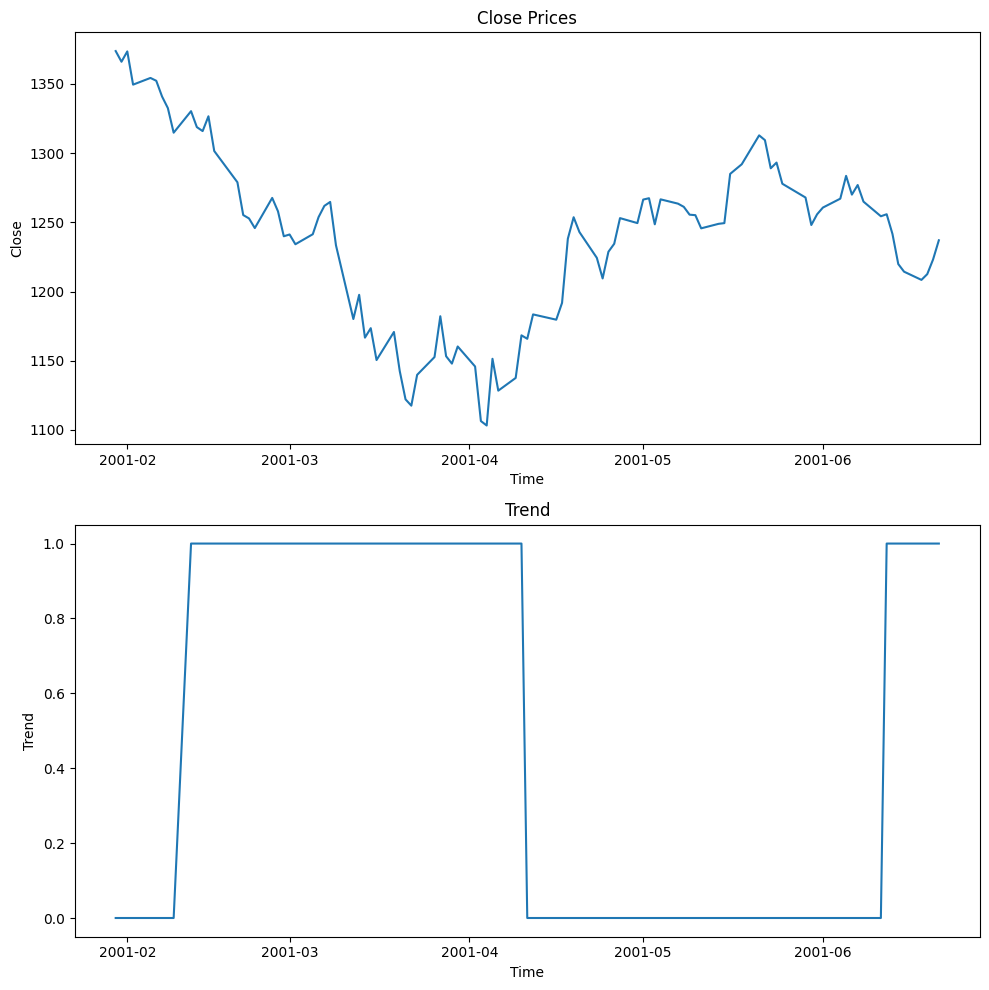

In [9]:
import matplotlib.pyplot as plt

# Create a figure with two vertical subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot the "Close" column in the first subplot
axs[0].plot(target_symbol_data['Close'][0:100])
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Close')
axs[0].set_title('Close Prices')

# Plot the "Trend" column in the second subplot
axs[1].plot(target_symbol_data['Trend'][0:100])
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Trend')
axs[1].set_title('Trend')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [10]:
y_test.shape, y_preds.shape, test_dates.shape

(torch.Size([184, 8, 2]), torch.Size([184, 8, 2]), (184, 8))

In [11]:
postprocessor = Postprocesser()
X_train, X_test, X_newest, y_train, y_test, y_preds = \
    postprocessor.check_shape(X_train, X_test, X_newest, y_train, y_test, y_preds, reshape=params['model_params'][params['model_type']]['reshape'])
test_trade_signals = postprocessor.process_signals(y_test, test_dates, False)
pred_trade_signals = postprocessor.process_signals(y_preds, test_dates, params['filter'])
newest_trade_signals = postprocessor.process_signals(y_pred_newest, y_newest_date, False)

In [12]:
y_pred_newest

tensor([[[0.1364, 0.8623],
         [0.7900, 0.2096],
         [0.9173, 0.0824],
         [0.9353, 0.0650],
         [0.9684, 0.0318],
         [0.9729, 0.0271],
         [0.9677, 0.0316],
         [0.9706, 0.0293]]])

In [13]:
max_indices = torch.argmax(y_pred_newest, dim=-1)

In [14]:
max_indices

tensor([[1, 0, 0, 0, 0, 0, 0, 0]])

In [15]:
newest_trade_signals['up_trend'] = y_pred_newest.detach().numpy()[0, :, 0]
newest_trade_signals['down_trend'] = y_pred_newest.detach().numpy()[0, :, 1]

In [16]:
newest_trade_signals

,Date,Signal,up_trend,down_trend
0,2021-01-04,,0.136399,0.862313
1,2021-01-05,Sell (first) (last),0.790043,0.209632
2,2021-01-06,,0.917264,0.082432
3,2021-01-07,,0.935257,0.064983
4,2021-01-08,,0.968364,0.031773
5,2021-01-11,,0.972926,0.027097
6,2021-01-12,,0.967720,0.031627
7,2021-01-13,,0.970630,0.029273


In [17]:
evaluator = Evaluator(params=params)
model_summary, pred_days_difference_results, pred_days_difference_abs_mean, backtesting_report, trade_summary, execution_time, confusion_matrix_info, y_test, y_preds = evaluator.generate_numericale_data(model,
                y_test, y_preds, target_symbol_data, pred_trade_signals, test_trade_signals, execution_time)



In [18]:
# with open('parameters.json', 'r') as f:
#     params = json.load(f)
    
# rp = ReversePrediction()
# model_summary, pred_days_difference_results, pred_days_difference_abs_mean, backtesting_report, trade_summary, execution_time, confusion_matrix_info, y_test, y_preds, test_trade_signals, y_pred_newest, pred_trade_signals, newest_trade_signals\
#     = rp.run(params)
confusion_matrix_info_json = json.dumps(confusion_matrix_info)
model_summary_json = json.dumps(model_summary)
backtesting_report_json = json.dumps(backtesting_report)
pred_days_difference_results_json = pred_days_difference_results.to_json()
trade_summary_json = json.dumps(trade_summary)
execution_time_json = json.dumps(execution_time)

response = {
    'msg': 'Received!',
    'usingData': params,
    'confusion_matrix_info': confusion_matrix_info_json,
    'model_summary': model_summary_json,
    'backtesting_report': backtesting_report_json,
    'pred_days_difference_results': pred_days_difference_results_json,
    'trade_summary': trade_summary_json,
    'execution_time': execution_time_json,
}


In [19]:
response

{'msg': 'Received!',
 'usingData': {'train_indices': ['^GSPC', '^IXIC', '^DJI', '^RUA'],
  'test_indices': '^GSPC',
  'start_date': '2001-01-01',
  'stop_date': '2021-01-01',
  'features_params': [{'type': 'Trend',
    'method': 'MA',
    'oder_days': 20,
    'ma_days': 20,
    'trend_days': 5},
   {'type': 'MACD', 'fastperiod': 5, 'slowperiod': 10, 'signalperiod': 9},
   {'type': 'ROC', 'trend_days': 5},
   {'type': 'Stochastic Oscillator', 'trend_days': 5},
   {'type': 'CCI', 'timeperiod': 14},
   {'type': 'RSI', 'timeperiod': 14},
   {'type': 'VMA', 'timeperiod': 20},
   {'type': 'pctChange'},
   {'type': '13W Treasury Yield',
    'start_date': '2001-01-01',
    'end_date': '2021-01-01'},
   {'type': '5Y Treasury Yield',
    'start_date': '2001-01-01',
    'end_date': '2021-01-01'},
   {'type': '10Y Treasury Yield',
    'start_date': '2001-01-01',
    'end_date': '2021-01-01'},
   {'type': '30Y Treasury Yield',
    'start_date': '2001-01-01',
    'end_date': '2021-01-01'},
   {'type